Name: Arwa Alabbad

Project: Project 3 Classification

MVP due date: 2/10/2019

In [66]:
import pandas as pd
import seaborn as sns
from sklearn.tree import DecisionTreeRegressor
from sklearn.metrics import mean_absolute_error
import matplotlib.pyplot as plt
import numpy as np
from sklearn.preprocessing import StandardScaler
from sklearn.model_selection import KFold
from sklearn.model_selection import train_test_split, cross_val_score,cross_validate
from sklearn.naive_bayes import GaussianNB, BernoulliNB
from sklearn.svm import SVC
from sklearn.tree import DecisionTreeClassifier
from sklearn.linear_model import LogisticRegression
from sklearn.ensemble import RandomForestClassifier, BaggingClassifier
from sklearn.metrics import confusion_matrix, accuracy_score, precision_score, recall_score, f1_score, classification_report
from xgboost import XGBClassifier
from sklearn.neighbors import KNeighborsClassifier
from sklearn.ensemble import (RandomForestClassifier, ExtraTreesClassifier, VotingClassifier, 
                              AdaBoostClassifier, BaggingRegressor)
from mlxtend.plotting import plot_decision_regions
from mlxtend.classifier import StackingClassifier # <-- note: this is not from sklearn!
from sklearn.preprocessing import PowerTransformer
from sklearn.model_selection import GridSearchCV
from sklearn.pipeline import Pipeline
from sklearn.feature_selection import SelectFromModel
from sklearn import linear_model, svm, naive_bayes, neighbors, ensemble
from sklearn.metrics import roc_auc_score
from sklearn.metrics import roc_curve
from sklearn.metrics import auc
import statsmodels.api as sm
from sklearn.feature_selection import mutual_info_classif


In [2]:
df = pd.read_csv('cardio_train.csv',sep=";")

In [3]:
df.head()

,id,age,gender,height,weight,ap_hi,ap_lo,cholesterol,gluc,smoke,alco,active,cardio
0,0,18393,2,168,62.0,110,80,1,1,0,0,1,0
1,1,20228,1,156,85.0,140,90,3,1,0,0,1,1
2,2,18857,1,165,64.0,130,70,3,1,0,0,0,1
3,3,17623,2,169,82.0,150,100,1,1,0,0,1,1
4,4,17474,1,156,56.0,100,60,1,1,0,0,0,0


In [4]:
df = df.drop(columns=['id'])

In [5]:
df.shape

(70000, 12)

In [6]:
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 70000 entries, 0 to 69999
Data columns (total 12 columns):
age            70000 non-null int64
gender         70000 non-null int64
height         70000 non-null int64
weight         70000 non-null float64
ap_hi          70000 non-null int64
ap_lo          70000 non-null int64
cholesterol    70000 non-null int64
gluc           70000 non-null int64
smoke          70000 non-null int64
alco           70000 non-null int64
active         70000 non-null int64
cardio         70000 non-null int64
dtypes: float64(1), int64(11)
memory usage: 6.4 MB


In [7]:
df['age'] = (df.age/365).round().astype('int')

In [8]:
# renaming 
df = df.rename(columns={'ap_hi': 'systolic_BP', 'ap_lo': 'diastolic_BP'})

In [9]:
df.describe()

,age,gender,height,weight,systolic_BP,diastolic_BP,cholesterol,gluc,smoke,alco,active,cardio
count,70000.000000,70000.000000,70000.000000,70000.000000,70000.000000,70000.000000,70000.000000,70000.000000,70000.000000,70000.000000,70000.000000,70000.000000
mean,53.338686,1.349571,164.359229,74.205690,128.817286,96.630414,1.366871,1.226457,0.088129,0.053771,0.803729,0.499700
std,6.765294,0.476838,8.210126,14.395757,154.011419,188.472530,0.680250,0.572270,0.283484,0.225568,0.397179,0.500003
min,30.000000,1.000000,55.000000,10.000000,-150.000000,-70.000000,1.000000,1.000000,0.000000,0.000000,0.000000,0.000000
25%,48.000000,1.000000,159.000000,65.000000,120.000000,80.000000,1.000000,1.000000,0.000000,0.000000,1.000000,0.000000
50%,54.000000,1.000000,165.000000,72.000000,120.000000,80.000000,1.000000,1.000000,0.000000,0.000000,1.000000,0.000000
75%,58.000000,2.000000,170.000000,82.000000,140.000000,90.000000,2.000000,1.000000,0.000000,0.000000,1.000000,1.000000
max,65.000000,2.000000,250.000000,200.000000,16020.000000,11000.000000,3.000000,3.000000,1.000000,1.000000,1.000000,1.000000


# 1.Cleaning 

## Back story on blood pressure readings 

* Systolic blood pressure (the first number) – indicates how much pressure your blood is exerting against your artery walls when the heart beats.

* Diastolic blood pressure (the second number) – indicates how much pressure your blood is exerting against your artery walls while the heart is resting between beats.

* Referenece: [American Heart Association (AHA)](https://www.heart.org/en/health-topics/high-blood-pressure/understanding-blood-pressure-readings)

* removing ouliers: 
    - Removing cases where Diastolic pressure is greater than Systolic.
    - Removing negative blood pressure 
    - Removing systolic blood pressure outside the range of (70 - 190 ), and diastolic outside the range (40 - 100 ).


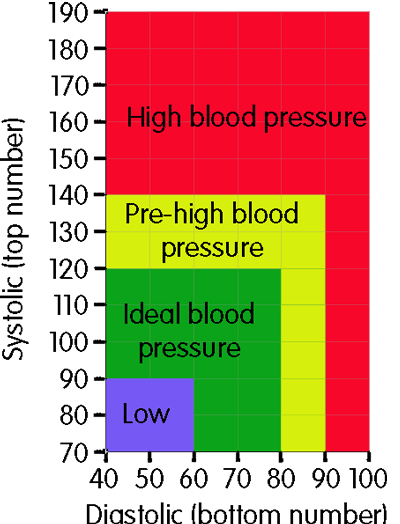

In [10]:
# How many cases where diastolic is greater than systolic 
oulier_BP = df[df['diastolic_BP'] > df['systolic_BP']]
oulier_BP.shape[0]

1234

In [11]:
df.drop(df[(df['systolic_BP'] > 190)  | (df['systolic_BP'] < 70)].index, inplace=True)

In [12]:
df.drop(df[(df['diastolic_BP'] > 100)  | (df['diastolic_BP'] < 40)].index, inplace=True)

In [13]:
outlier_BP = df[df['diastolic_BP'] > df['systolic_BP']]
outlier_BP.shape[0]

6

In [14]:
df.drop(outlier_BP.index, inplace=True)

In [15]:
(70000 - df.shape[0]) # how many records have been dropped

2069

## Removing height and weight outilers

I noticed that min height is 55 cm and min weight is 10 kg given that the min age is 29 years, so those will be considered as outliers.
The same thing for the max values, they have irrelevant data entries. 

(array([1.7000e+01, 6.0000e+00, 2.1000e+01, 5.8000e+01, 4.0810e+03,
        5.2162e+04, 1.1537e+04, 4.8000e+01, 0.0000e+00, 1.0000e+00]),
 array([ 55. ,  74.5,  94. , 113.5, 133. , 152.5, 172. , 191.5, 211. ,
        230.5, 250. ]),
 <a list of 10 Patch objects>)

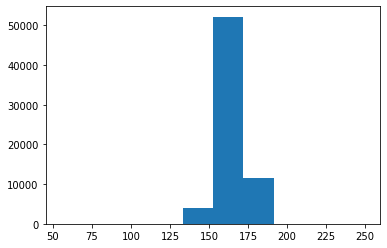

In [16]:
plt.hist(df.height,label= 'Height')

(array([   25.,   105.,   935.,  7172., 19315., 22872., 13173.,  3527.,
          663.,    57.]),
 array([128., 135., 142., 149., 156., 163., 170., 177., 184., 191., 198.]),
 <a list of 10 Patch objects>)

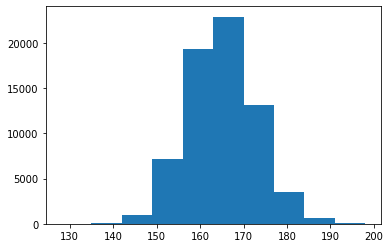

In [17]:
df_height=df.loc[(df.height > 125) & (df.height < 200)]
plt.hist(df_height.height)

In [18]:
df.drop(df[(df['height'] < 125)  | (df['height'] > 200)].index, inplace=True)

(array([6.0000e+00, 7.9700e+02, 2.2536e+04, 3.3080e+04, 9.5690e+03,
        1.5300e+03, 2.6300e+02, 3.9000e+01, 2.5000e+01, 3.0000e+00]),
 array([ 11. ,  29.9,  48.8,  67.7,  86.6, 105.5, 124.4, 143.3, 162.2,
        181.1, 200. ]),
 <a list of 10 Patch objects>)

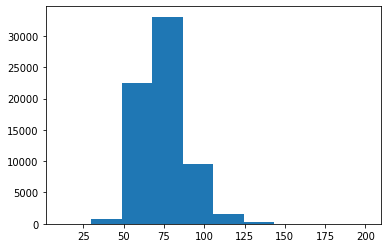

In [19]:
plt.hist(df.weight, label='Weight')

(array([3.1860e+03, 2.2835e+04, 2.5761e+04, 1.0939e+04, 3.6790e+03,
        1.0060e+03, 2.5100e+02, 5.8000e+01, 1.9000e+01, 1.7000e+01]),
 array([ 41. ,  54.7,  68.4,  82.1,  95.8, 109.5, 123.2, 136.9, 150.6,
        164.3, 178. ]),
 <a list of 10 Patch objects>)

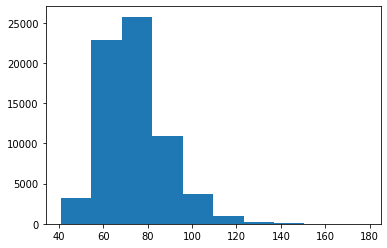

In [20]:
df_real_weight=df.loc[(df.weight>40) & (df.weight<180)]
plt.hist(df_real_weight.weight)

In [21]:
df.drop(df[(df['weight'] < 40)  | (df['weight'] > 180)].index, inplace=True)

# 2.EDA

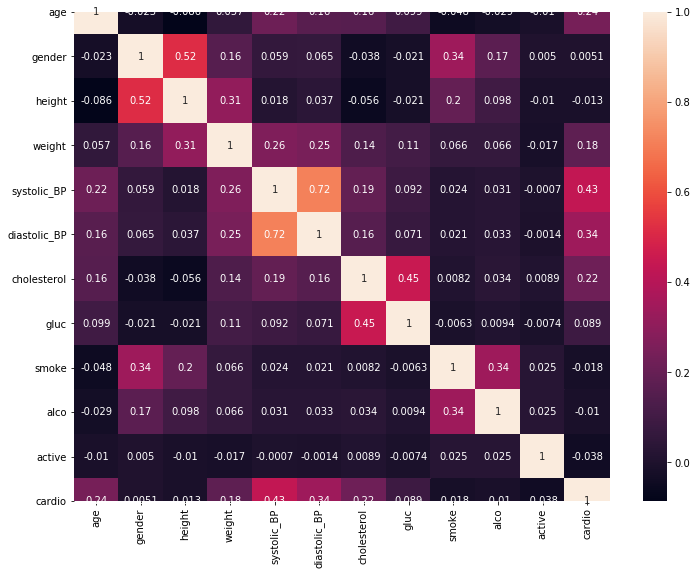

In [22]:
# Plot Heatmap which shows correlation between features.
plt.figure(figsize=(12,9))
sns.heatmap(df.corr(), annot=True)

In [23]:
df.groupby('gender')['height'].mean()
#then 1: women 2: men

gender
1    161.470973
2    170.008906
Name: height, dtype: float64

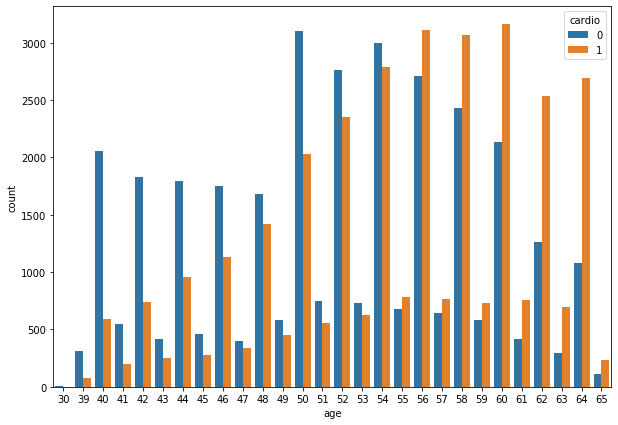

In [24]:
plt.figure(figsize=(10,7))
sns.countplot(x='age', hue='cardio', data = df);
# from the age of 55 and above more poeple are diagnosed with cardio

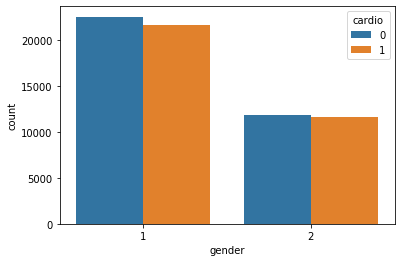

In [25]:
sns.countplot(x='gender', hue='cardio', data = df)

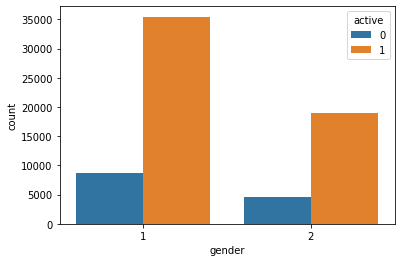

In [26]:
sns.countplot(x='gender', hue='active', data = df)

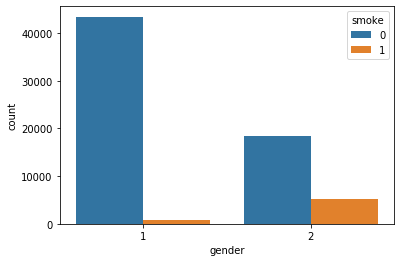

In [27]:
sns.countplot(x='gender', hue='smoke', data = df)

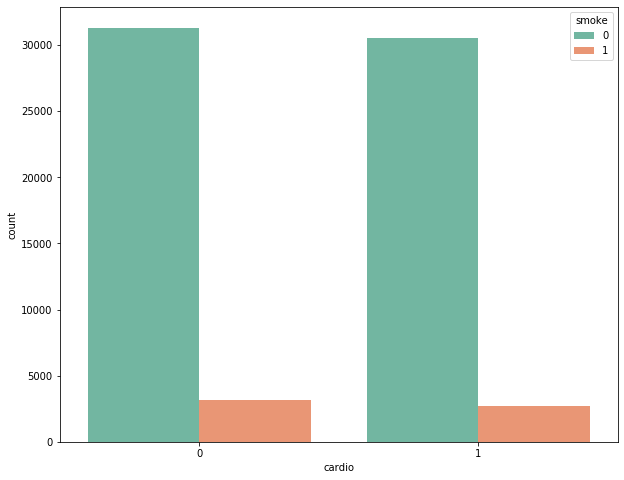

In [156]:
plt.figure(figsize=(10,8))
sns.countplot(x='cardio', hue='smoke', palette='Set2', data = df)

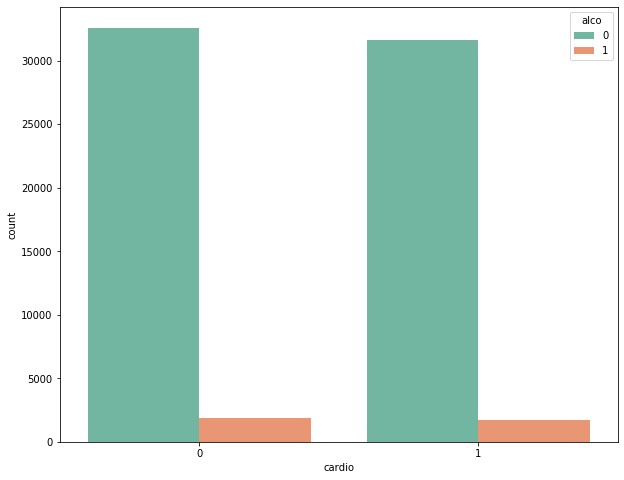

In [157]:
plt.figure(figsize=(10,8))
sns.countplot(x='cardio', hue='alco', data = df, palette='Set2')

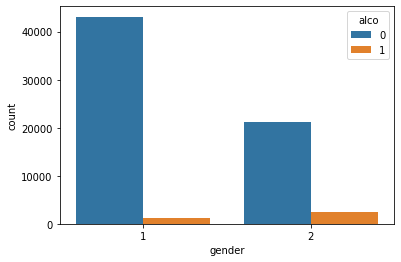

In [28]:
sns.countplot(x='gender', hue='alco', data = df)

In [152]:
df['alco'].value_counts(normalize=True)*100

0    94.71068
1     5.28932
Name: alco, dtype: float64

In [153]:
df['smoke'].value_counts(normalize=True)*100

0    91.24445
1     8.75555
Name: smoke, dtype: float64

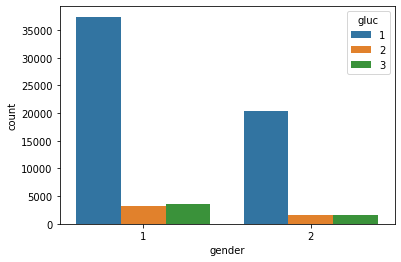

In [29]:
sns.countplot(x='gender', hue='gluc', data = df)
# 1: normal, 2: above normal, 3: well above normal

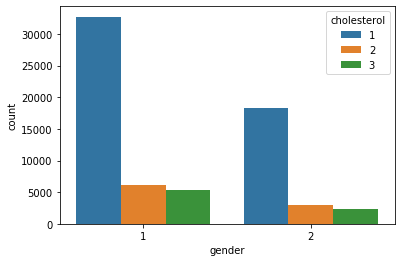

In [30]:
sns.countplot(x='gender', hue='cholesterol', data = df)
# 1: normal, 2: above normal, 3: well above normal

In [31]:
df['gender'].value_counts(normalize=True)*100

1    65.2197
2    34.7803
Name: gender, dtype: float64

Checking if the target is balanced

In [32]:
df['cardio'].value_counts(normalize=True)*100

0    50.897532
1    49.102468
Name: cardio, dtype: float64

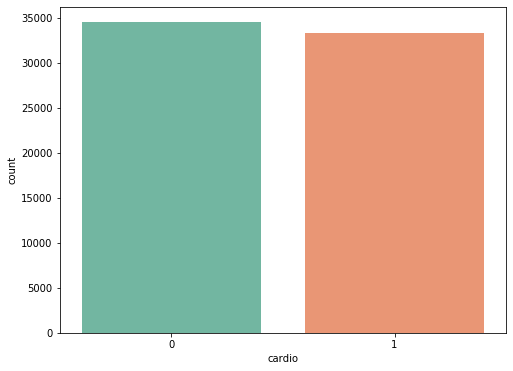

In [33]:
plt.figure(figsize=(8,6))
sns.countplot(x="cardio", palette='Set2',data=df)

In [34]:
df['cardio'].value_counts()

0    34507
1    33290
Name: cardio, dtype: int64

# 3. Feature Eng

In [35]:
X = df.drop('cardio', axis=1)
y = df.cardio

In [36]:
# Split into validation and training data
X, X_test, y, y_test = train_test_split(X, y, test_size=0.2, random_state=42)

In [37]:
# Fit on LogisticRegression, using train data, CV=3
#base model
print('LogisticRegression Model:')
log_CV = pd.DataFrame(cross_validate(LogisticRegression(), X, y, cv = 3, return_train_score=True, scoring = ['accuracy', 'precision', 'recall', 'f1']))
log_CV.mean()


LogisticRegression Model:


C:\Users\Arwa\Anaconda3\envs\metis\lib\site-packages\sklearn\linear_model\logistic.py:432: FutureWarning: Default solver will be changed to 'lbfgs' in 0.22. Specify a solver to silence this warning.
  FutureWarning)
C:\Users\Arwa\Anaconda3\envs\metis\lib\site-packages\sklearn\linear_model\logistic.py:432: FutureWarning: Default solver will be changed to 'lbfgs' in 0.22. Specify a solver to silence this warning.
  FutureWarning)
C:\Users\Arwa\Anaconda3\envs\metis\lib\site-packages\sklearn\linear_model\logistic.py:432: FutureWarning: Default solver will be changed to 'lbfgs' in 0.22. Specify a solver to silence this warning.
  FutureWarning)


fit_time           0.710772
score_time         0.032990
test_accuracy      0.726847
train_accuracy     0.727382
test_precision     0.752169
train_precision    0.752856
test_recall        0.663720
train_recall       0.664132
test_f1            0.705175
train_f1           0.705716
dtype: float64

In [38]:
X_2 = X.copy()

In [39]:
X_test_2 = X_test.copy()

In [40]:
X_2['bmi'] = (X_2.weight / ((X_2.height/100)**2)).round(2)

In [41]:
X_2.head()

,age,gender,height,weight,systolic_BP,diastolic_BP,cholesterol,gluc,smoke,alco,active,bmi
935,54,2,167,72.0,120,80,1,1,0,0,0,25.82
7323,50,1,174,78.0,110,70,1,1,0,0,1,25.76
45796,56,2,168,75.0,120,80,1,1,1,0,1,26.57
12799,50,1,163,90.0,130,90,1,2,0,0,1,33.87
18430,59,1,156,54.0,110,70,1,1,0,0,1,22.19


In [42]:
X_test_2['bmi'] = (X_test_2.weight / ((X_test_2.height/100)**2)).round(2)

(array([8.2120e+03, 3.7325e+04, 7.7940e+03, 8.2200e+02, 7.2000e+01,
        1.0000e+01, 0.0000e+00, 1.0000e+00, 0.0000e+00, 1.0000e+00]),
 array([ 13.52 ,  22.856,  32.192,  41.528,  50.864,  60.2  ,  69.536,
         78.872,  88.208,  97.544, 106.88 ]),
 <a list of 10 Patch objects>)

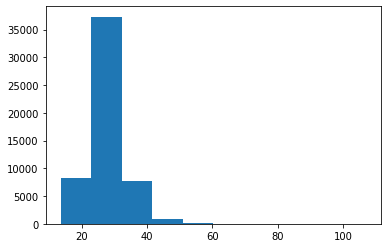

In [43]:
plt.hist(X_2.bmi)

In [45]:
pt = PowerTransformer()
bmi_transformed = pt.fit_transform(X_2.bmi.values.reshape(-1,1))
X_2['bmi'] = bmi_transformed

(array([5.0000e+00, 4.8000e+01, 3.1600e+02, 1.9650e+03, 1.2103e+04,
        2.0415e+04, 1.4210e+04, 4.7440e+03, 4.2300e+02, 8.0000e+00]),
 array([-5.65398519, -4.65352429, -3.65306338, -2.65260248, -1.65214157,
        -0.65168067,  0.34878024,  1.34924115,  2.34970205,  3.35016296,
         4.35062386]),
 <a list of 10 Patch objects>)

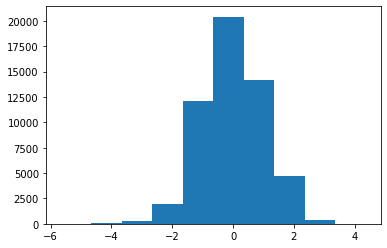

In [46]:
plt.hist(X_2.bmi)

In [47]:
scaler = StandardScaler()
scaler.fit(X_2)
X_2_scaled = scaler.transform(X_2)

In [48]:
scaler.fit(X_test_2)
X_test_2_scaled = scaler.transform(X_test_2)

In [49]:
print('LogisticRegression Model:')
log_CV_2 = pd.DataFrame(cross_validate(LogisticRegression(), X_2_scaled, y, cv = 3, return_train_score=True, scoring = ['accuracy', 'precision', 'recall', 'f1']))
log_CV_2.mean()

LogisticRegression Model:


C:\Users\Arwa\Anaconda3\envs\metis\lib\site-packages\sklearn\linear_model\logistic.py:432: FutureWarning: Default solver will be changed to 'lbfgs' in 0.22. Specify a solver to silence this warning.
  FutureWarning)
C:\Users\Arwa\Anaconda3\envs\metis\lib\site-packages\sklearn\linear_model\logistic.py:432: FutureWarning: Default solver will be changed to 'lbfgs' in 0.22. Specify a solver to silence this warning.
  FutureWarning)
C:\Users\Arwa\Anaconda3\envs\metis\lib\site-packages\sklearn\linear_model\logistic.py:432: FutureWarning: Default solver will be changed to 'lbfgs' in 0.22. Specify a solver to silence this warning.
  FutureWarning)


fit_time           0.157952
score_time         0.028321
test_accuracy      0.726294
train_accuracy     0.726617
test_precision     0.750700
train_precision    0.751024
test_recall        0.664619
train_recall       0.665031
test_f1            0.705034
train_f1           0.705415
dtype: float64

C:\Users\Arwa\Anaconda3\envs\metis\lib\site-packages\sklearn\linear_model\logistic.py:432: FutureWarning: Default solver will be changed to 'lbfgs' in 0.22. Specify a solver to silence this warning.
  FutureWarning)


Mean Absolute Error: 0.26972713864306785
              precision    recall  f1-score   support

           0       0.71      0.79      0.75      5554
           1       0.75      0.67      0.71      5294

    accuracy                           0.73     10848
   macro avg       0.73      0.73      0.73     10848
weighted avg       0.73      0.73      0.73     10848



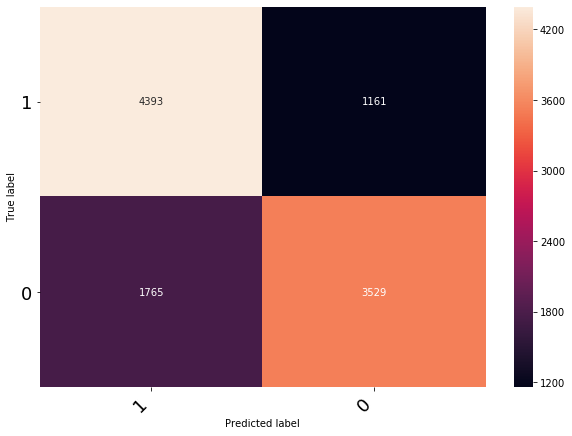

In [54]:
model_test(LogisticRegression(),X_2_scaled , y)

In [55]:
sample = X_2.copy()
sample['cardio'] = y.copy()
sample.head()

,age,gender,height,weight,systolic_BP,diastolic_BP,cholesterol,gluc,smoke,alco,active,bmi,cardio
935,54,2,167,72.0,120,80,1,1,0,0,0,-0.164253,0
7323,50,1,174,78.0,110,70,1,1,0,0,1,-0.178308,1
45796,56,2,168,75.0,120,80,1,1,1,0,1,0.005909,0
12799,50,1,163,90.0,130,90,1,2,0,0,1,1.260646,0
18430,59,1,156,54.0,110,70,1,1,0,0,1,-1.154401,0


C:\Users\Arwa\Anaconda3\envs\metis\lib\site-packages\statsmodels\nonparametric\kde.py:487: RuntimeWarning: invalid value encountered in true_divide
  binned = fast_linbin(X, a, b, gridsize) / (delta * nobs)
C:\Users\Arwa\Anaconda3\envs\metis\lib\site-packages\statsmodels\nonparametric\kdetools.py:34: RuntimeWarning: invalid value encountered in double_scalars
  FAC1 = 2*(np.pi*bw/RANGE)**2


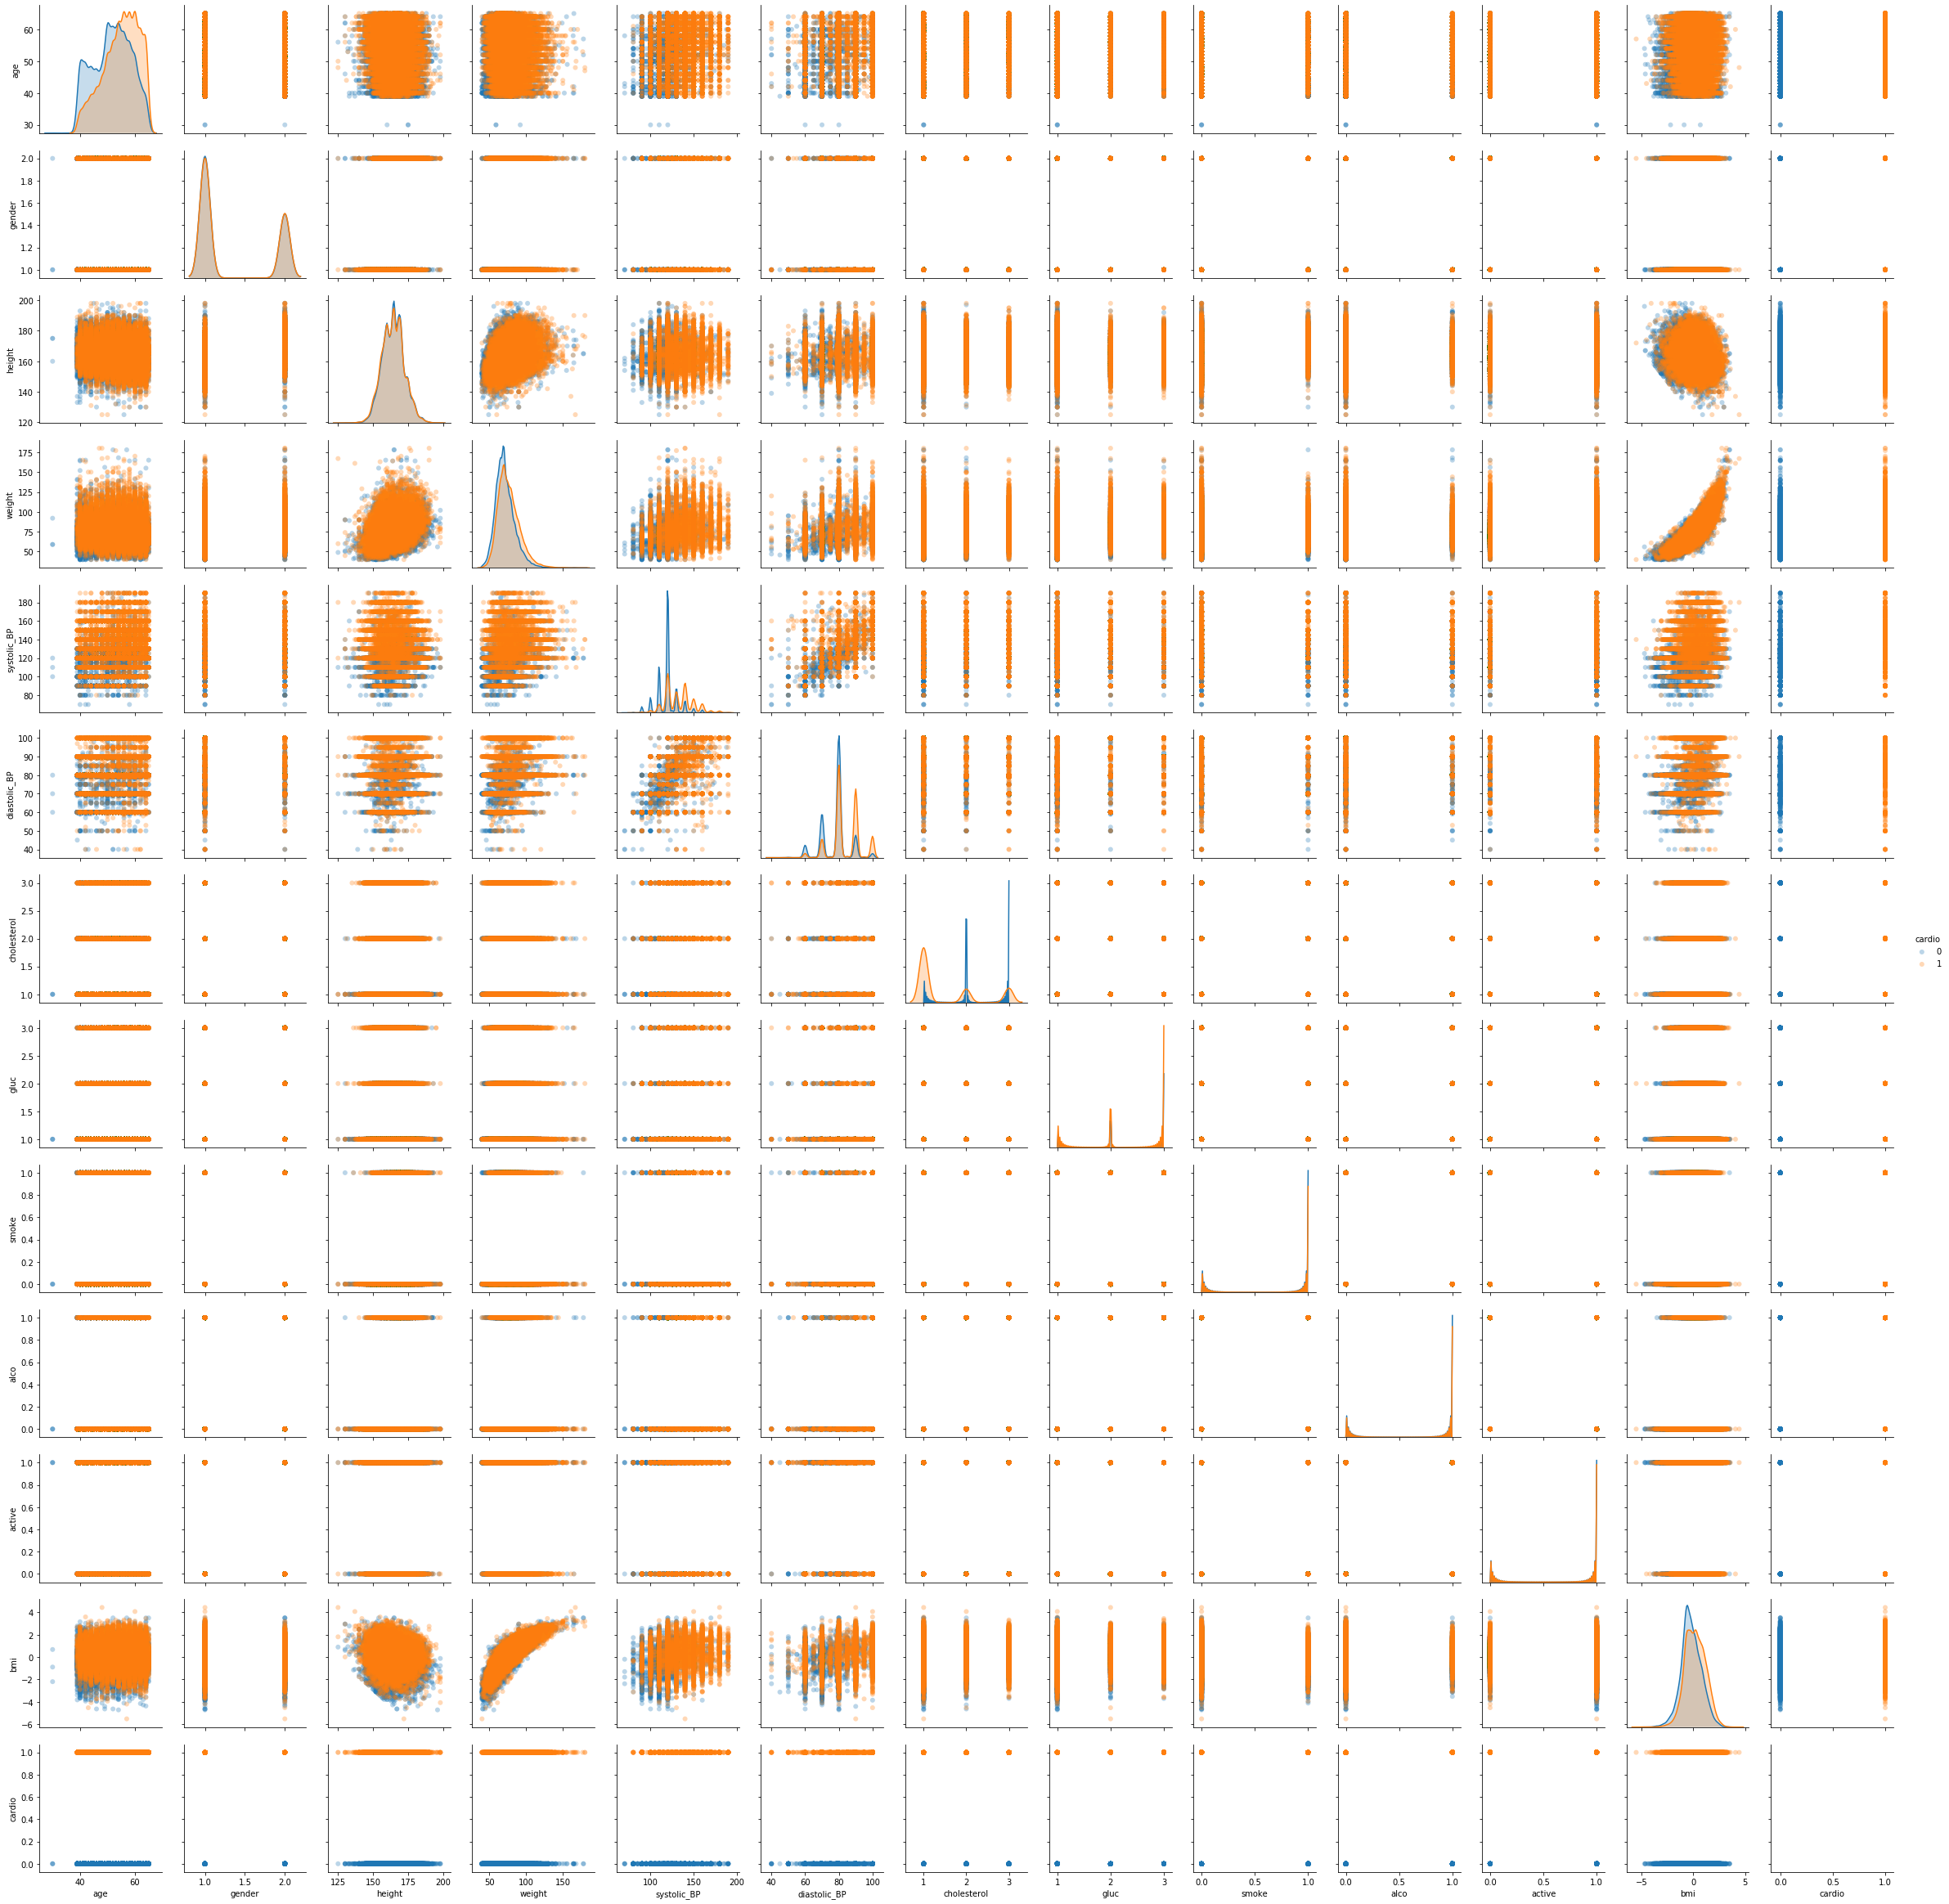

In [139]:
def plot_features(df, sample_size=500):
    sns.pairplot(df,hue='cardio', plot_kws=dict(alpha=.3, edgecolor='none'))

plot_features(sample)

### Features Selection

In [56]:
sel = SelectFromModel(RandomForestClassifier(n_estimators = 100))
sel.fit(X_2, y)

SelectFromModel(estimator=RandomForestClassifier(bootstrap=True,
                                                 class_weight=None,
                                                 criterion='gini',
                                                 max_depth=None,
                                                 max_features='auto',
                                                 max_leaf_nodes=None,
                                                 min_impurity_decrease=0.0,
                                                 min_impurity_split=None,
                                                 min_samples_leaf=1,
                                                 min_samples_split=2,
                                                 min_weight_fraction_leaf=0.0,
                                                 n_estimators=100, n_jobs=None,
                                                 oob_score=False,
                                                 random_state=None, verbose=0,
  

In [57]:
sel.get_support()
selected_feat= X_2.columns[(sel.get_support())]
len(selected_feat)

6

In [58]:
print(selected_feat)

Index(['age', 'height', 'weight', 'systolic_BP', 'diastolic_BP', 'bmi'], dtype='object')


In [108]:
X_3 = X_2[['age', 'height', 'weight', 'systolic_BP', 'diastolic_BP','bmi', 'cholesterol', 'gluc', 'gender']]

In [109]:
X_test_3 = X_test_2[['age', 'height', 'weight', 'systolic_BP', 'diastolic_BP','bmi', 'cholesterol', 'gluc', 'gender']]

In [110]:
scaler2 = StandardScaler()
scaler2.fit(X_3)
X_3_scaled = scaler2.transform(X_3)

In [111]:
scaler2.fit(X_test_3)
X_test_3_scaled = scaler2.transform(X_test_3)

In [117]:
feature_scores = mutual_info_classif(X_2, y)

for score, fname in sorted(zip(feature_scores, X_2.columns), reverse=True):
    print(fname, (score).round(5))

systolic_BP 0.11721
diastolic_BP 0.0695
age 0.03135
cholesterol 0.02572
bmi 0.02143
weight 0.01847
gluc 0.00734
height 0.0058
active 0.00546
gender 0.00304
alco 0.0008
smoke 0.0


Text(0.5, 1.0, 'Feature Importances')

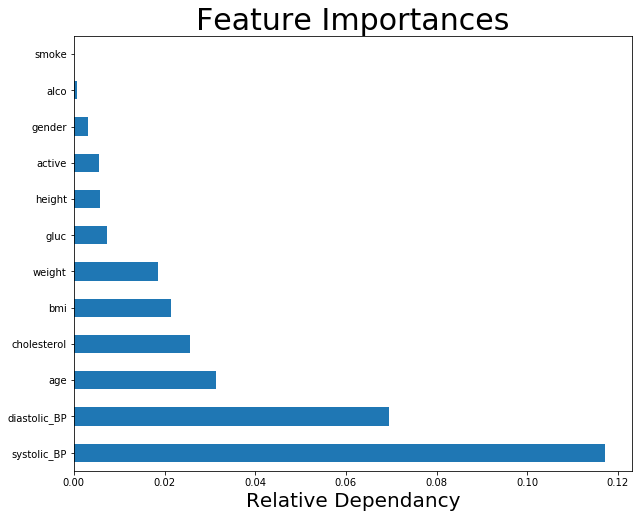

In [151]:
plt.figure(figsize=(10,8))
(pd.Series(feature_scores, index=X_2.columns).nlargest(12).plot(kind='barh'))   
plt.xlabel('Relative Dependancy',  fontdict= {'fontsize': 20})
plt.title('Feature Importances', fontdict= {'fontsize': 30})


In [113]:
print('LogisticRegression Model:')
log_CV_3 = pd.DataFrame(cross_validate(LogisticRegression(), X_3_scaled, y, cv = 3, return_train_score=True, scoring = ['accuracy', 'precision', 'recall', 'f1']))
log_CV_3.mean()

LogisticRegression Model:


C:\Users\Arwa\Anaconda3\envs\metis\lib\site-packages\sklearn\linear_model\logistic.py:432: FutureWarning: Default solver will be changed to 'lbfgs' in 0.22. Specify a solver to silence this warning.
  FutureWarning)
C:\Users\Arwa\Anaconda3\envs\metis\lib\site-packages\sklearn\linear_model\logistic.py:432: FutureWarning: Default solver will be changed to 'lbfgs' in 0.22. Specify a solver to silence this warning.
  FutureWarning)
C:\Users\Arwa\Anaconda3\envs\metis\lib\site-packages\sklearn\linear_model\logistic.py:432: FutureWarning: Default solver will be changed to 'lbfgs' in 0.22. Specify a solver to silence this warning.
  FutureWarning)


fit_time           0.136290
score_time         0.026990
test_accuracy      0.724745
train_accuracy     0.724846
test_precision     0.750410
train_precision    0.750751
test_recall        0.660423
train_recall       0.660124
test_f1            0.702539
train_f1           0.702527
dtype: float64

C:\Users\Arwa\Anaconda3\envs\metis\lib\site-packages\sklearn\linear_model\logistic.py:432: FutureWarning: Default solver will be changed to 'lbfgs' in 0.22. Specify a solver to silence this warning.
  FutureWarning)


Mean Absolute Error: 0.27064896755162243
              precision    recall  f1-score   support

           0       0.71      0.79      0.75      5554
           1       0.75      0.66      0.71      5294

    accuracy                           0.73     10848
   macro avg       0.73      0.73      0.73     10848
weighted avg       0.73      0.73      0.73     10848



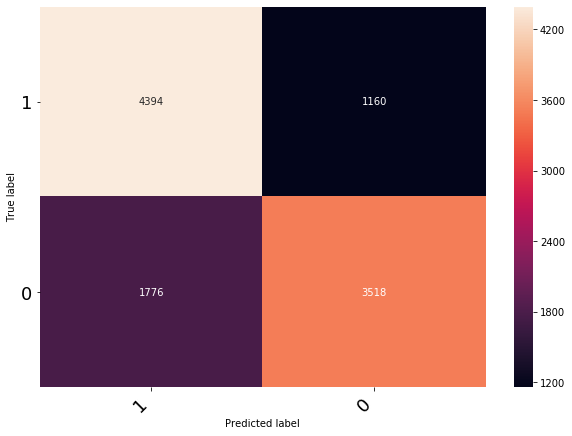

In [114]:
model_test(LogisticRegression(),X_3_scaled , y)

# 3. Modeling

In [65]:
class HelpEstimatorSelection:
    def __init__(self, transformer, models, params):
        if not set(models.keys()).issubset(set(params.keys())):
            missing_params = list(set(models.keys()) - set(params.keys()))
            raise ValueError("Some estimators are missing parameters: %s" % missing_params)
        self.transformer = transformer
        self.models = models
        self.params = params
        self.keys = models.keys()
        self.grid_searches = {}
    
        
    def fit(self, X, y, cv=3, n_jobs=3, verbose=1, scoring=None, refit=False):
        def build_pipeline(model):
            return Pipeline([('trans', self.transformer), ('clf', model)])
    
        for key in self.keys:
            print("Running GridSearchCV for %s." % key)
            model = self.models[key]
            pipe = build_pipeline(model)
            params = self.params[key]
            gs = GridSearchCV(pipe, params, cv=cv, n_jobs=n_jobs,
                              verbose=verbose, scoring=scoring, refit=refit,
                              return_train_score=True)
            gs.fit(X,y)
            self.grid_searches[key] = gs    
    def score_summary(self, sort_by='mean_score'):
        def row(key, scores, params):
            d = {
                 'estimator': key,
                 'min_score': min(scores),
                 'max_score': max(scores),
                 'mean_score': np.mean(scores),
                 'std_score': np.std(scores),
            }
            return pd.Series({**params,**d})
        rows = []
        for k in self.grid_searches:
            print(k)
            params = self.grid_searches[k].cv_results_['params']
            scores = []
            for i in range(self.grid_searches[k].cv):
                key = "split{}_test_score".format(i)
                r = self.grid_searches[k].cv_results_[key]        
                scores.append(r.reshape(len(params),1))
            all_scores = np.hstack(scores)
            for p, s in zip(params,all_scores):
                rows.append((row(k, s, p)))
        df = pd.concat(rows, axis=1, sort=True).T.sort_values([sort_by], ascending=False)
        columns = ['estimator', 'min_score', 'mean_score', 'max_score', 'std_score']
        columns = columns + [c for c in df.columns if c not in columns]
        return df[columns]

In [75]:
models1 = {
    'GaussianNB': GaussianNB(),
    'KNeighborsClassifier':KNeighborsClassifier(),
}
params1 = {
    'GaussianNB': { 'clf__var_smoothing': [0.5, 1] },
    'KNeighborsClassifier':{
        'clf__n_neighbors': range(1, 20),
        'clf__weights': ['distance', 'uniform'],
    }
}

In [76]:
helper1 = HelpEstimatorSelection(transformer, models1, params1)
helper1.fit(X_2, y, scoring='f1', n_jobs=2)
helper1.score_summary(sort_by='max_score')

Running GridSearchCV for GaussianNB.
Fitting 3 folds for each of 2 candidates, totalling 6 fits


[Parallel(n_jobs=2)]: Using backend LokyBackend with 2 concurrent workers.
[Parallel(n_jobs=2)]: Done   6 out of   6 | elapsed:    3.0s finished
[Parallel(n_jobs=2)]: Using backend LokyBackend with 2 concurrent workers.


Running GridSearchCV for KNeighborsClassifier.
Fitting 3 folds for each of 38 candidates, totalling 114 fits


[Parallel(n_jobs=2)]: Done  46 tasks      | elapsed:  5.3min


GaussianNB
KNeighborsClassifier


[Parallel(n_jobs=2)]: Done 114 out of 114 | elapsed: 18.5min finished


,estimator,min_score,mean_score,max_score,std_score,clf__n_neighbors,clf__var_smoothing,clf__weights
39,KNeighborsClassifier,0.702465,0.704021,0.704878,0.00110217,19,NaN,uniform
35,KNeighborsClassifier,0.701111,0.702103,0.702787,0.000717829,17,NaN,uniform
31,KNeighborsClassifier,0.700575,0.701409,0.702071,0.000622481,15,NaN,uniform
27,KNeighborsClassifier,0.699642,0.700406,0.701039,0.00057797,13,NaN,uniform
38,KNeighborsClassifier,0.700328,0.700665,0.700914,0.000247455,19,NaN,distance
36,KNeighborsClassifier,0.697744,0.699533,0.700733,0.00128938,18,NaN,distance
23,KNeighborsClassifier,0.698449,0.699168,0.700377,0.000860477,11,NaN,uniform
32,KNeighborsClassifier,0.697187,0.698598,0.700224,0.00124915,16,NaN,distance
34,KNeighborsClassifier,0.698675,0.699476,0.69996,0.000570404,17,NaN,distance
26,KNeighborsClassifier,0.696131,0.69731,0.699225,0.0013661,13,NaN,distance


In [48]:
transformer = StandardScaler()

In [77]:
models2 = {
    
    'RandomForestClassifier':RandomForestClassifier(),
    'AdaBoostClassifier':AdaBoostClassifier(),
    'LogisticRegressionClassifier': LogisticRegression(),
}
params2 = {
    'RandomForestClassifier':{
        'clf__n_estimators': [50, 100, 150],
        'clf__max_depth': [50, 100, 150],
        'clf__max_features': [2, 4, 6, 8, 10, 12],
        
    },
    'AdaBoostClassifier':{'clf__learning_rate': [1e-3, 1e-2, 1e-1, 1, 1e1, 1e2, 1e3],
                                 'clf__n_estimators': [50, 100, 150]},
    'LogisticRegressionClassifier': { 'clf__penalty': ['l1', 'l2'], 'clf__C': [0.1, 1] },
    
    
}

In [78]:
helper2 = HelpEstimatorSelection(transformer, models2, params2)
helper2.fit(X_2, y, scoring='f1', n_jobs=2)
helper2.score_summary(sort_by='max_score').all()

Running GridSearchCV for RandomForestClassifier.
Fitting 3 folds for each of 54 candidates, totalling 162 fits


[Parallel(n_jobs=2)]: Using backend LokyBackend with 2 concurrent workers.
[Parallel(n_jobs=2)]: Done  46 tasks      | elapsed:  4.0min
[Parallel(n_jobs=2)]: Done 162 out of 162 | elapsed: 14.7min finished
[Parallel(n_jobs=2)]: Using backend LokyBackend with 2 concurrent workers.


Running GridSearchCV for AdaBoostClassifier.
Fitting 3 folds for each of 21 candidates, totalling 63 fits


[Parallel(n_jobs=2)]: Done  46 tasks      | elapsed:  1.3min
[Parallel(n_jobs=2)]: Done  63 out of  63 | elapsed:  1.9min finished
[Parallel(n_jobs=2)]: Using backend LokyBackend with 2 concurrent workers.


Running GridSearchCV for LogisticRegressionClassifier.
Fitting 3 folds for each of 4 candidates, totalling 12 fits
RandomForestClassifier
AdaBoostClassifier
LogisticRegressionClassifier


[Parallel(n_jobs=2)]: Done  12 out of  12 | elapsed:    2.0s finished


,estimator,min_score,mean_score,max_score,std_score,clf__C,clf__learning_rate,clf__max_depth,clf__max_features,clf__n_estimators,clf__penalty
76,LogisticRegressionClassifier,0.701946,0.70516,0.708925,0.00287607,0.1,NaN,NaN,NaN,NaN,l2
78,LogisticRegressionClassifier,0.701988,0.705137,0.708772,0.00279094,1,NaN,NaN,NaN,NaN,l2
77,LogisticRegressionClassifier,0.70203,0.705057,0.708611,0.00271237,1,NaN,NaN,NaN,NaN,l1
75,LogisticRegressionClassifier,0.702049,0.704661,0.707718,0.00233571,0.1,NaN,NaN,NaN,NaN,l1
2,RandomForestClassifier,0.698824,0.702048,0.705223,0.0026128,NaN,NaN,50,2,150,NaN
...,...,...,...,...,...,...,...,...,...,...,...
71,AdaBoostClassifier,0,0,0,0,NaN,100,NaN,NaN,150,NaN
72,AdaBoostClassifier,0,0,0,0,NaN,1000,NaN,NaN,50,NaN
73,AdaBoostClassifier,0,0,0,0,NaN,1000,NaN,NaN,100,NaN
74,AdaBoostClassifier,0,0,0,0,NaN,1000,NaN,NaN,150,NaN


In [84]:
models3 = {
    'SVC': SVC(),
    'XGBClassifier': XGBClassifier(),
}
params3 = {
    'SVC': [
        {'clf__kernel': ['linear'], 'clf__C': [1, 10]},
        {'clf__kernel': ['rbf'], 'clf__C': [1, 10], 'clf__gamma': [0.001, 0.0001]},
    ],'XGBClassifier':{
                     'clf__max_depth': [50, 100, 150],
                     'clf__max_features': [2, 4, 6, 8, 10, 12]},
    
    
}

In [86]:
helper3 = HelpEstimatorSelection(transformer, models3, params3)
helper3.fit(X_2, y, scoring='f1', n_jobs=2)
helper3.score_summary(sort_by='max_score')

Running GridSearchCV for SVC.
Fitting 3 folds for each of 6 candidates, totalling 18 fits


[Parallel(n_jobs=2)]: Using backend LokyBackend with 2 concurrent workers.
[Parallel(n_jobs=2)]: Done  18 out of  18 | elapsed: 19.8min finished
[Parallel(n_jobs=2)]: Using backend LokyBackend with 2 concurrent workers.


Running GridSearchCV for XGBClassifier.
Fitting 3 folds for each of 18 candidates, totalling 54 fits


[Parallel(n_jobs=2)]: Done  46 tasks      | elapsed: 27.6min


SVC
XGBClassifier


[Parallel(n_jobs=2)]: Done  54 out of  54 | elapsed: 33.1min finished


,estimator,min_score,mean_score,max_score,std_score,clf__C,clf__gamma,clf__kernel,clf__max_depth,clf__max_features
4,SVC,0.693986,0.696153,0.697807,0.00160174,10,0.001,rbf,NaN,NaN
2,SVC,0.692469,0.693512,0.694389,0.000792667,1,0.001,rbf,NaN,NaN
0,SVC,0.692929,0.693214,0.693394,0.000203934,1,NaN,linear,NaN,NaN
1,SVC,0.692972,0.693214,0.693394,0.000178066,10,NaN,linear,NaN,NaN
5,SVC,0.691387,0.692483,0.69311,0.000777681,10,0.0001,rbf,NaN,NaN
6,XGBClassifier,0.687801,0.689334,0.691516,0.00158459,NaN,NaN,NaN,50,2
7,XGBClassifier,0.687801,0.689334,0.691516,0.00158459,NaN,NaN,NaN,50,4
8,XGBClassifier,0.687801,0.689334,0.691516,0.00158459,NaN,NaN,NaN,50,6
9,XGBClassifier,0.687801,0.689334,0.691516,0.00158459,NaN,NaN,NaN,50,8
10,XGBClassifier,0.687801,0.689334,0.691516,0.00158459,NaN,NaN,NaN,50,10


In [177]:
def make_roc(model):    
    plt.rcParams['font.size'] = 14
    #X, X_test, y, y_test = train_test_split(X, y, test_size=0.2, random_state=42)
    logit_roc_auc = roc_auc_score(y_test, model.predict(X_test_2_scaled))
    fpr, tpr, thresholds = roc_curve(y_test, model.predict_proba(X_test_2_scaled)[:,1])
    roc_auc = auc(fpr,tpr)
    plt.figure(figsize=(4,4))
    # Plotting our Baseline..
    plt.plot([0,1],[0,1],'C1--', linewidth=2.0)
    plt.plot(fpr, tpr, 'C9',label='AUC = %0.3f'% roc_auc,linewidth=2.0)
    plt.legend(loc='lower right')
    plt.xlabel('False Positive Rate')
    plt.ylabel('True Positive Rate');

In [51]:
def make_report(model):
    from sklearn.metrics import confusion_matrix
    y_pred_rep = model.predict(X_test_3_scaled)
    accuracy_best =model.score(X_test_3_scaled, y_test)
    print("\nAccuracy of the best model is :",accuracy_best)
    confusion_matrix = confusion_matrix(y_test, y_pred_rep)
    print("\nConfusion Matrix \n-------------------\n",confusion_matrix)
    print("\nClassification Report \n---------------------")
    print(classification_report(y_test, y_pred_rep))

In [52]:
def print_confusion_matrix(confusion_matrix, class_names, figsize = (10,7), fontsize=18):
    """Prints a confusion matrix, as returned by sklearn.metrics.confusion_matrix, as a heatmap.
    
    Arguments
    ---------
    confusion_matrix: numpy.ndarray
        The numpy.ndarray object returned from a call to sklearn.metrics.confusion_matrix. 
        Similarly constructed ndarrays can also be used.
    class_names: list
        An ordered list of class names, in the order they index the given confusion matrix.
    figsize: tuple
        A 2-long tuple, the first value determining the horizontal size of the ouputted figure,
        the second determining the vertical size. Defaults to (10,7).
    fontsize: int
        Font size for axes labels. Defaults to 14.
        
    Returns
    -------
    matplotlib.figure.Figure
        The resulting confusion matrix figure
    """
    df_cm = pd.DataFrame(confusion_matrix, index=class_names, columns=class_names, )
    fig = plt.figure(figsize=figsize)
    try:
        heatmap = sns.heatmap(df_cm, annot=True, fmt="d")
    except ValueError:
        raise ValueError("Confusion matrix values must be integers.")
    heatmap.yaxis.set_ticklabels(heatmap.yaxis.get_ticklabels(), rotation=0, ha='right', fontsize=fontsize)
    heatmap.xaxis.set_ticklabels(heatmap.xaxis.get_ticklabels(), rotation=45, ha='right', fontsize=fontsize)
    plt.xlim(0,len(class_names))
    plt.ylim(len(class_names),0)
    plt.ylabel('True label')
    plt.xlabel('Predicted label')
    return fig

In [53]:
def model_test(model, X, y):
    # perform train/val split
    X, X_test, y, y_test = train_test_split(X, y, test_size=0.2, random_state=42)
    model.fit(X, y)
    pred = model.predict(X_test)
    print('Mean Absolute Error:', mean_absolute_error(y_test,pred))
    #print('Accuracy score:', accuracy_score(y_test, pred))
    conf = confusion_matrix(y_test, pred)
    print(classification_report(y_test, pred))
    print_confusion_matrix(conf, ['1', '0'])
   

In [119]:
# Fit on GaussianNB, using train data, CV=3
print('GaussianNB Model:')
GaussianNB_CV = pd.DataFrame(cross_validate(GaussianNB(), X_2_scaled, y, cv = 3, return_train_score=True, scoring = ['accuracy', 'precision', 'recall', 'f1']))
GaussianNB_CV.mean()
#it is perfict

GaussianNB Model:


fit_time           0.029324
score_time         0.061325
test_accuracy      0.710880
train_accuracy     0.710834
test_precision     0.749114
train_precision    0.748696
test_recall        0.620378
train_recall       0.620903
test_f1            0.678679
train_f1           0.678837
dtype: float64

Mean Absolute Error: 0.2818952802359882
              precision    recall  f1-score   support

           0       0.69      0.81      0.75      5554
           1       0.76      0.62      0.68      5294

    accuracy                           0.72     10848
   macro avg       0.72      0.72      0.71     10848
weighted avg       0.72      0.72      0.72     10848



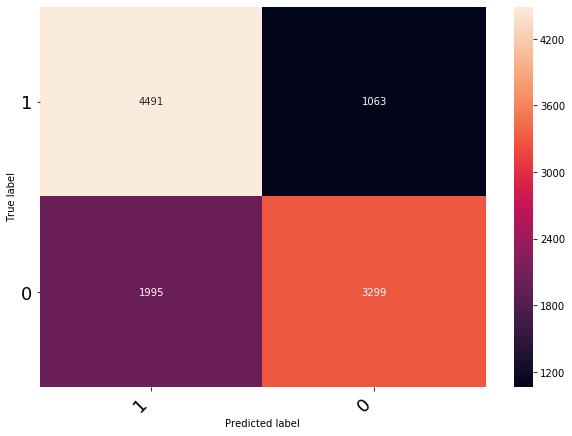

In [125]:
model_test(GaussianNB(), X_2_scaled, y)

In [126]:
# Fit on DecisionTree, using train data, CV=3
print('DecisionTree Model:')
DT_CV = pd.DataFrame(cross_validate(DecisionTreeClassifier(), X_2_scaled, y, cv = 3, return_train_score=True, scoring = ['accuracy', 'precision', 'recall', 'f1']))
DT_CV.mean()
#it is overfitting!

DecisionTree Model:


fit_time           0.223933
score_time         0.043326
test_accuracy      0.633756
train_accuracy     0.981148
test_precision     0.630781
train_precision    0.996059
test_recall        0.617082
train_recall       0.965518
test_f1            0.623855
train_f1           0.980550
dtype: float64

Mean Absolute Error: 0.36015855457227136
              precision    recall  f1-score   support

           0       0.64      0.66      0.65      5554
           1       0.63      0.62      0.63      5294

    accuracy                           0.64     10848
   macro avg       0.64      0.64      0.64     10848
weighted avg       0.64      0.64      0.64     10848



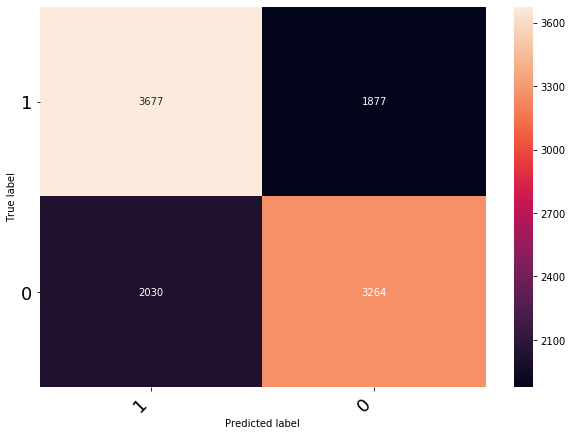

In [128]:
model_test(DecisionTreeClassifier(), X_2_scaled, y)

In [129]:
# Fit on LogisticRegression, using train data, CV=3
print('LogisticRegression Model:')
log_CV = pd.DataFrame(cross_validate(LogisticRegression(), X_2_scaled, y, cv = 3, return_train_score=True, scoring = ['accuracy', 'precision', 'recall', 'f1']))
log_CV.mean()
# very good

LogisticRegression Model:


C:\Users\Arwa\Anaconda3\envs\metis\lib\site-packages\sklearn\linear_model\logistic.py:432: FutureWarning: Default solver will be changed to 'lbfgs' in 0.22. Specify a solver to silence this warning.
  FutureWarning)
C:\Users\Arwa\Anaconda3\envs\metis\lib\site-packages\sklearn\linear_model\logistic.py:432: FutureWarning: Default solver will be changed to 'lbfgs' in 0.22. Specify a solver to silence this warning.
  FutureWarning)
C:\Users\Arwa\Anaconda3\envs\metis\lib\site-packages\sklearn\linear_model\logistic.py:432: FutureWarning: Default solver will be changed to 'lbfgs' in 0.22. Specify a solver to silence this warning.
  FutureWarning)


fit_time           0.171611
score_time         0.034322
test_accuracy      0.726368
train_accuracy     0.726561
test_precision     0.750742
train_precision    0.750971
test_recall        0.664769
train_recall       0.664956
test_f1            0.705137
train_f1           0.705350
dtype: float64

C:\Users\Arwa\Anaconda3\envs\metis\lib\site-packages\sklearn\linear_model\logistic.py:432: FutureWarning: Default solver will be changed to 'lbfgs' in 0.22. Specify a solver to silence this warning.
  FutureWarning)


Mean Absolute Error: 0.2696349557522124
              precision    recall  f1-score   support

           0       0.71      0.79      0.75      5554
           1       0.75      0.67      0.71      5294

    accuracy                           0.73     10848
   macro avg       0.73      0.73      0.73     10848
weighted avg       0.73      0.73      0.73     10848



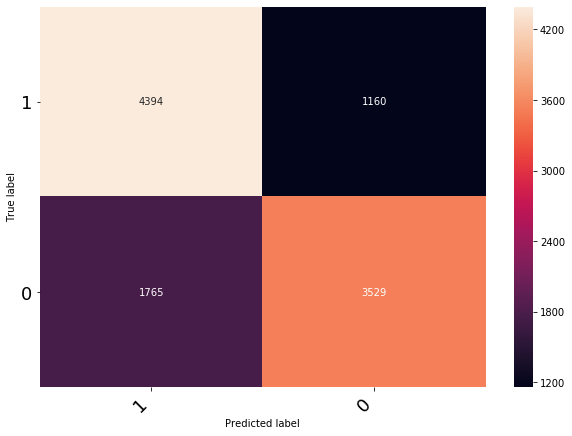

In [130]:
model_test(LogisticRegression(), X_2_scaled, y) 

In [131]:
# Fit on XGBoost, with preset parameter, using train data, CV=3
print('XGBClassifier Model:')
XGB_CV = pd.DataFrame(cross_validate(XGBClassifier(), X_2_scaled, y, cv = 3, return_train_score=True, scoring = ['accuracy', 'precision', 'recall', 'f1']))
XGB_CV.mean()
# also good

XGBClassifier Model:


fit_time           2.788071
score_time         0.227587
test_accuracy      0.733687
train_accuracy     0.735660
test_precision     0.750921
train_precision    0.753278
test_recall        0.686720
train_recall       0.688425
test_f1            0.717377
train_f1           0.719388
dtype: float64

Mean Absolute Error: 0.26281342182890854
              precision    recall  f1-score   support

           0       0.73      0.78      0.75      5554
           1       0.75      0.69      0.72      5294

    accuracy                           0.74     10848
   macro avg       0.74      0.74      0.74     10848
weighted avg       0.74      0.74      0.74     10848



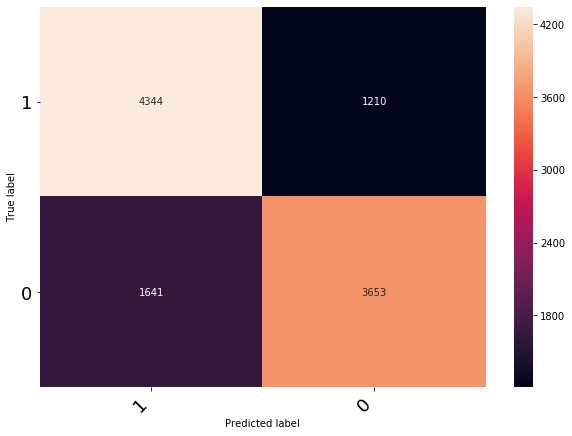

In [132]:
model_test(XGBClassifier(), X_2_scaled, y)

In [46]:
knn_scores = []
def knn_model(X,y):
    X, X_test, y, y_test = train_test_split(X, y, test_size=0.2, random_state=42)
    for k in range(1,21):
        knn_classifier = KNeighborsClassifier(n_neighbors = k)
        knn_classifier.fit(X, y)
        knn_scores.append(knn_classifier.score(X_test, y_test).round(2))
knn_model(X,y)

Text(0.5, 1.0, 'K Neighbors Classifier scores for different K values')

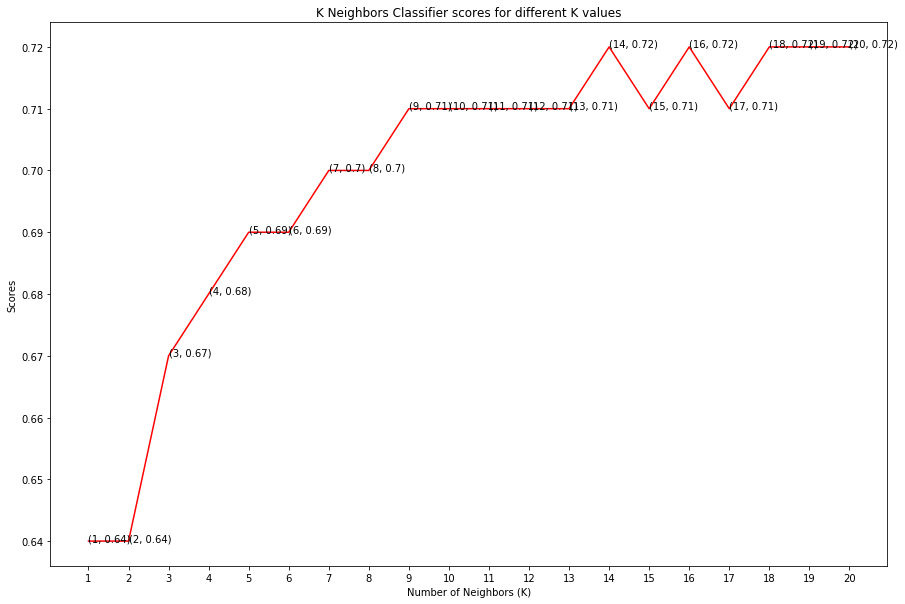

In [47]:
plt.figure(figsize=(15,10))
plt.plot([k for k in range(1, 21)], knn_scores, color = 'red')

for i in range(1,21):
    plt.text(i, knn_scores[i-1], (i, knn_scores[i-1]))
plt.xticks([i for i in range(1, 21)])
plt.xlabel('Number of Neighbors (K)')
plt.ylabel('Scores')
plt.title('K Neighbors Classifier scores for different K values')

In [48]:
print('KNeighborsClassifier Model:')
KNN_CV = pd.DataFrame(cross_validate(KNeighborsClassifier(n_neighbors=14), X_2_scaled, y, cv = 3, return_train_score=True,scoring = ['accuracy', 'precision', 'recall', 'f1']))
KNN_CV.mean()

KNeighborsClassifier Model:


fit_time            0.162945
score_time         20.221035
test_accuracy       0.716393
train_accuracy      0.747893
test_precision      0.743344
train_precision     0.779140
test_recall         0.647275
train_recall        0.680764
test_f1             0.691983
train_f1            0.726634
dtype: float64

Mean Absolute Error: 0.27986725663716816
              precision    recall  f1-score   support

           0       0.70      0.78      0.74      5554
           1       0.74      0.66      0.70      5294

    accuracy                           0.72     10848
   macro avg       0.72      0.72      0.72     10848
weighted avg       0.72      0.72      0.72     10848



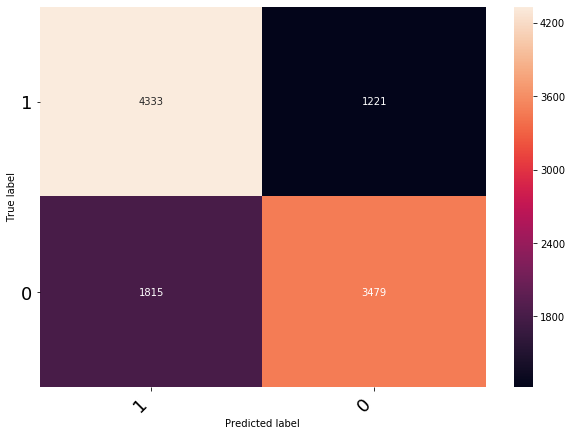

In [49]:
model_test(KNeighborsClassifier(n_neighbors=14), X_2_scaled, y)

In [50]:
print('RandomForestClassifier Model:')
rf_CV = pd.DataFrame(cross_validate(RandomForestClassifier(), X_2_scaled, y, cv = 3, return_train_score=True, scoring = ['accuracy', 'precision', 'recall', 'f1']))
rf_CV.mean()
# overfitting

RandomForestClassifier Model:


C:\Users\Arwa\Anaconda3\envs\metis\lib\site-packages\sklearn\ensemble\forest.py:245: FutureWarning: The default value of n_estimators will change from 10 in version 0.20 to 100 in 0.22.
  "10 in version 0.20 to 100 in 0.22.", FutureWarning)
C:\Users\Arwa\Anaconda3\envs\metis\lib\site-packages\sklearn\ensemble\forest.py:245: FutureWarning: The default value of n_estimators will change from 10 in version 0.20 to 100 in 0.22.
  "10 in version 0.20 to 100 in 0.22.", FutureWarning)
C:\Users\Arwa\Anaconda3\envs\metis\lib\site-packages\sklearn\ensemble\forest.py:245: FutureWarning: The default value of n_estimators will change from 10 in version 0.20 to 100 in 0.22.
  "10 in version 0.20 to 100 in 0.22.", FutureWarning)


fit_time           0.418530
score_time         0.230938
test_accuracy      0.689529
train_accuracy     0.962304
test_precision     0.698064
train_precision    0.974367
test_recall        0.650684
train_recall       0.948361
test_f1            0.673534
train_f1           0.961188
dtype: float64

C:\Users\Arwa\Anaconda3\envs\metis\lib\site-packages\sklearn\ensemble\forest.py:245: FutureWarning: The default value of n_estimators will change from 10 in version 0.20 to 100 in 0.22.
  "10 in version 0.20 to 100 in 0.22.", FutureWarning)


Mean Absolute Error: 0.3077064896755162
              precision    recall  f1-score   support

           0       0.69      0.74      0.71      5554
           1       0.70      0.65      0.67      5294

    accuracy                           0.69     10848
   macro avg       0.69      0.69      0.69     10848
weighted avg       0.69      0.69      0.69     10848



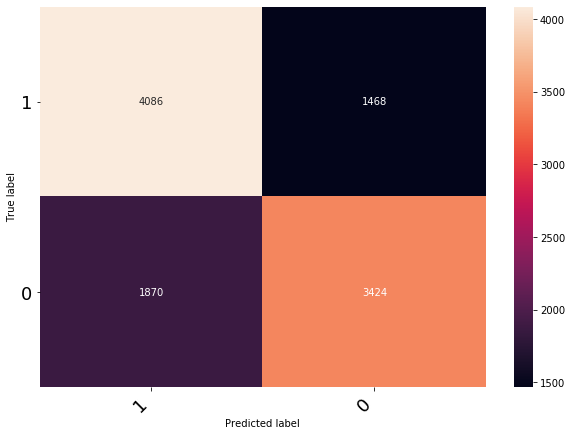

In [51]:
model_test(RandomForestClassifier(), X_2_scaled, y)

In [52]:
print('SVC Model:')
svc_CV = pd.DataFrame(cross_validate(SVC(), X_2_scaled, y, cv = 3, return_train_score=True, scoring = ['accuracy', 'precision', 'recall', 'f1']))
svc_CV.mean()
#takes sooo long

SVC Model:


C:\Users\Arwa\Anaconda3\envs\metis\lib\site-packages\sklearn\svm\base.py:193: FutureWarning: The default value of gamma will change from 'auto' to 'scale' in version 0.22 to account better for unscaled features. Set gamma explicitly to 'auto' or 'scale' to avoid this warning.
  "avoid this warning.", FutureWarning)
C:\Users\Arwa\Anaconda3\envs\metis\lib\site-packages\sklearn\svm\base.py:193: FutureWarning: The default value of gamma will change from 'auto' to 'scale' in version 0.22 to account better for unscaled features. Set gamma explicitly to 'auto' or 'scale' to avoid this warning.
  "avoid this warning.", FutureWarning)
C:\Users\Arwa\Anaconda3\envs\metis\lib\site-packages\sklearn\svm\base.py:193: FutureWarning: The default value of gamma will change from 'auto' to 'scale' in version 0.22 to account better for unscaled features. Set gamma explicitly to 'auto' or 'scale' to avoid this warning.
  "avoid this warning.", FutureWarning)


fit_time           53.281132
score_time         42.084417
test_accuracy       0.731475
train_accuracy      0.737347
test_precision      0.759229
train_precision     0.766614
test_recall         0.665480
train_recall        0.670481
test_f1             0.709268
train_f1            0.715332
dtype: float64

C:\Users\Arwa\Anaconda3\envs\metis\lib\site-packages\sklearn\svm\base.py:193: FutureWarning: The default value of gamma will change from 'auto' to 'scale' in version 0.22 to account better for unscaled features. Set gamma explicitly to 'auto' or 'scale' to avoid this warning.
  "avoid this warning.", FutureWarning)


Mean Absolute Error: 0.26345870206489674
              precision    recall  f1-score   support

           0       0.72      0.80      0.76      5554
           1       0.76      0.67      0.71      5294

    accuracy                           0.74     10848
   macro avg       0.74      0.74      0.73     10848
weighted avg       0.74      0.74      0.74     10848



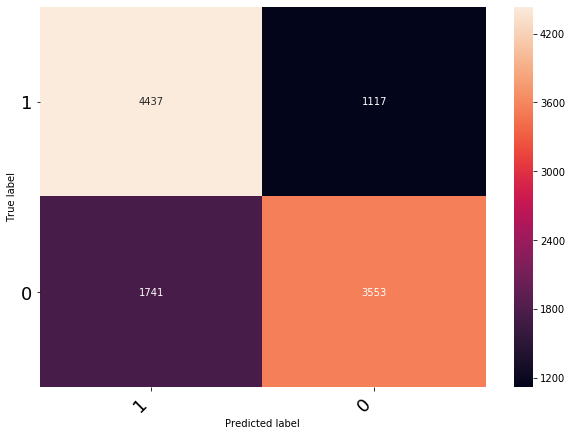

In [53]:
model_test(SVC(), X_2_scaled, y)

In [55]:
lr_model = linear_model.LogisticRegression(solver="lbfgs")
nb_model = naive_bayes.GaussianNB()
knn_model = neighbors.KNeighborsClassifier()
svc_model = svm.SVC(probability=True, gamma="scale")
rf_model = ensemble.RandomForestClassifier(n_estimators=100)
dt_model = DecisionTreeClassifier()
ada_model = ensemble.AdaBoostClassifier()
xgb_model = XGBClassifier()

model_names = ["lr_model", "nb_model", "knn_model", "svc_model", "rf_model", "dt_model", "ada_model", "xgb_model"]

In [56]:
model_vars = [eval(n) for n in model_names]
model_list = list(zip(model_names, model_vars))

In [57]:
# Quick peek at each model performance
def evaluate_models(X,y, model_names):
    X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)
    for model_name in model_names:
        curr_model = eval(model_name)
        curr_model.fit(X_train, y_train)
        print(f'{model_name} score: {curr_model.score(X_test, y_test)}')

In [58]:
evaluate_models(X_2_scaled,y, model_names)

lr_model score: 0.730457227138643
nb_model score: 0.7202249262536873
knn_model score: 0.6976401179941003
svc_model score: 0.7365412979351033
rf_model score: 0.7092551622418879
dt_model score: 0.6388274336283186
ada_model score: 0.7312868731563422
xgb_model score: 0.7366334808259587


In [170]:
# create voting classifier
voting_classifer = VotingClassifier(estimators=smaller_model_list,
                                    voting='soft', #<-- sklearn calls this hard voting
                                    n_jobs=-1)
voting_classifer.fit(X_2_scaled, y)

VotingClassifier(estimators=[('lr_model',
                              LogisticRegression(C=1.0, class_weight=None,
                                                 dual=False, fit_intercept=True,
                                                 intercept_scaling=1,
                                                 l1_ratio=None, max_iter=100,
                                                 multi_class='warn',
                                                 n_jobs=None, penalty='l2',
                                                 random_state=None,
                                                 solver='lbfgs', tol=0.0001,
                                                 verbose=0, warm_start=False)),
                             ('nb_model',
                              GaussianNB(priors=None, var_smoothing=1e-09)),
                             ('ada_model',
                              Ad...
                                            colsample_bynode=1,
                      

Mean Absolute Error: 0.26742256637168144
              precision    recall  f1-score   support

           0       0.71      0.81      0.76      5554
           1       0.77      0.65      0.70      5294

    accuracy                           0.73     10848
   macro avg       0.74      0.73      0.73     10848
weighted avg       0.74      0.73      0.73     10848



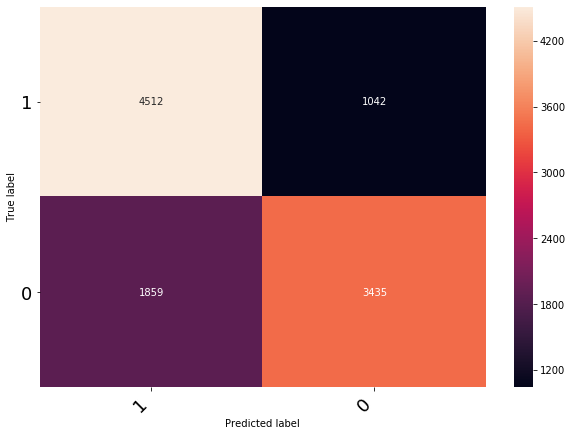

In [171]:
model_test(voting_classifer, X_2_scaled, y)

In [ ]:
model_names = ["lr_model", "nb_model", "knn_model", "svc_model", "rf_model", "dt_model", "ada_model", "xgb_model"]

In [60]:
smaller_model_names = ["lr_model", "nb_model", "ada_model", "xgb_model"]

In [61]:
smaller_model_vars = [eval(n) for n in smaller_model_names]
smaller_model_list = list(zip(smaller_model_names, smaller_model_vars))

In [162]:
stacked = StackingClassifier(
    classifiers=smaller_model_vars, meta_classifier=BernoulliNB(), use_probas=False)

In [163]:
stacked.fit(X_2_scaled, y)

StackingClassifier(average_probas=False,
                   classifiers=[LogisticRegression(C=1.0, class_weight=None,
                                                   dual=False,
                                                   fit_intercept=True,
                                                   intercept_scaling=1,
                                                   l1_ratio=None, max_iter=100,
                                                   multi_class='warn',
                                                   n_jobs=None, penalty='l2',
                                                   random_state=None,
                                                   solver='lbfgs', tol=0.0001,
                                                   verbose=0,
                                                   warm_start=False),
                                GaussianNB(priors=None, var_smoothing=1e-09),
                                AdaBoostClassifie...
                                   

Mean Absolute Error: 0.2650258112094395
Accuracy score: 0.7349741887905604
              precision    recall  f1-score   support

           0       0.72      0.79      0.75      5554
           1       0.75      0.68      0.72      5294

    accuracy                           0.73     10848
   macro avg       0.74      0.73      0.73     10848
weighted avg       0.74      0.73      0.73     10848



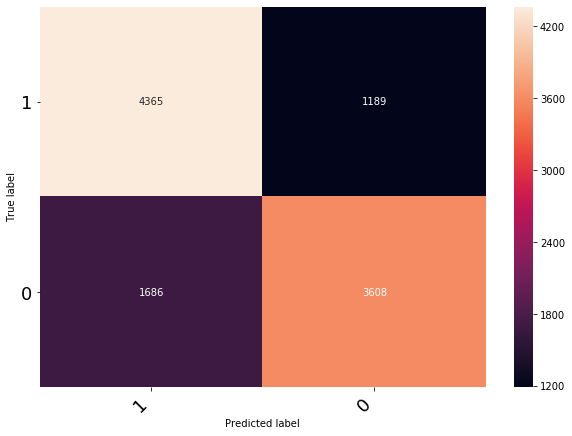

In [82]:
model_test(stacked, X_2_scaled, y)

In [72]:
print('stack Model:')
stack_CV = pd.DataFrame(cross_validate(stacked, X_2_scaled, y, cv = 3, return_train_score=True, scoring = ['accuracy', 'precision', 'recall', 'f1']))
stack_CV.mean()

stack Model:


fit_time           3.880957
score_time         0.784413
test_accuracy      0.730571
train_accuracy     0.732000
test_precision     0.751271
train_precision    0.752785
test_recall        0.676606
train_recall       0.678236
test_f1            0.711984
train_f1           0.713566
dtype: float64

In [84]:
stacked_2 = StackingClassifier(
    classifiers=model_vars, meta_classifier=BernoulliNB(), use_probas=False)

In [85]:
stacked_2.fit(X_2_scaled, y)

StackingClassifier(average_probas=False,
                   classifiers=[LogisticRegression(C=1.0, class_weight=None,
                                                   dual=False,
                                                   fit_intercept=True,
                                                   intercept_scaling=1,
                                                   l1_ratio=None, max_iter=100,
                                                   multi_class='warn',
                                                   n_jobs=None, penalty='l2',
                                                   random_state=None,
                                                   solver='lbfgs', tol=0.0001,
                                                   verbose=0,
                                                   warm_start=False),
                                GaussianNB(priors=None, var_smoothing=1e-09),
                                KNeighborsClassif...
                                   

In [86]:
print('stack 2 Model:')
stack_2_CV = pd.DataFrame(cross_validate(stacked_2, X_2_scaled, y, cv = 3, return_train_score=True, scoring = ['accuracy', 'precision', 'recall', 'f1']))
stack_2_CV.mean()

stack 2 Model:


fit_time           336.683145
score_time          60.484887
test_accuracy        0.714844
train_accuracy       0.930721
test_precision       0.711611
train_precision      0.898823
test_recall          0.707286
train_recall         0.968234
test_f1              0.709441
train_f1             0.932238
dtype: float64

Mean Absolute Error: 0.2821718289085546
              precision    recall  f1-score   support

           0       0.73      0.72      0.72      5554
           1       0.71      0.71      0.71      5294

    accuracy                           0.72     10848
   macro avg       0.72      0.72      0.72     10848
weighted avg       0.72      0.72      0.72     10848



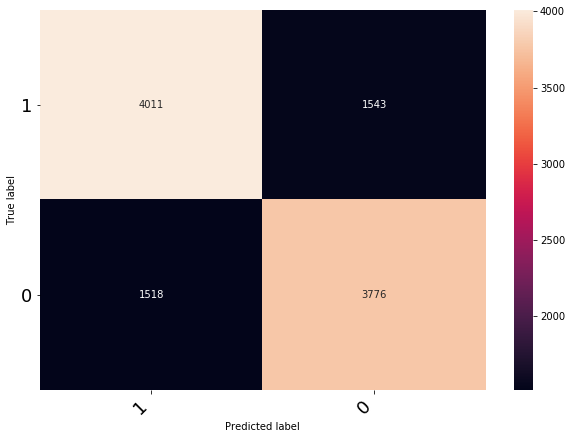

In [87]:
model_test(stacked_2, X_2_scaled, y)

In [93]:
#Bagging 
bg = BaggingClassifier(XGBClassifier(), n_estimators = 100)

Mean Absolute Error: 0.2623525073746313
              precision    recall  f1-score   support

           0       0.73      0.78      0.75      5554
           1       0.75      0.69      0.72      5294

    accuracy                           0.74     10848
   macro avg       0.74      0.74      0.74     10848
weighted avg       0.74      0.74      0.74     10848



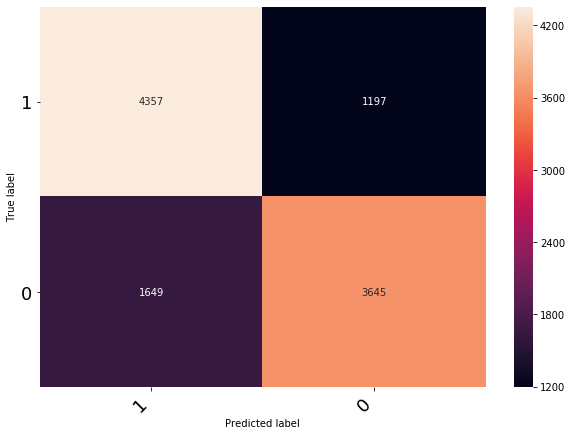

In [94]:
model_test(bg, X_2_scaled, y )

In [134]:
bag_lr_cl = BaggingClassifier(LogisticRegression(solver="lbfgs"),random_state=42, n_estimators=100)

In [135]:
print('Bagging of logistic regression model:')
bag_lr = pd.DataFrame(cross_validate(
        estimator=bag_lr_cl, X = X_2_scaled,y = y,
        cv=3,
        return_train_score=True,
        scoring = ['accuracy', 'precision', 'recall', 'f1'],
    ))
bag_lr.mean()

Bagging of logistic regression model:


fit_time           6.406259
score_time         1.143963
test_accuracy      0.726460
train_accuracy     0.726764
test_precision     0.750944
train_precision    0.751511
test_recall        0.664694
train_recall       0.664619
test_f1            0.705185
train_f1           0.705398
dtype: float64

Mean Absolute Error: 0.2696349557522124
              precision    recall  f1-score   support

           0       0.71      0.79      0.75      5554
           1       0.75      0.67      0.71      5294

    accuracy                           0.73     10848
   macro avg       0.73      0.73      0.73     10848
weighted avg       0.73      0.73      0.73     10848



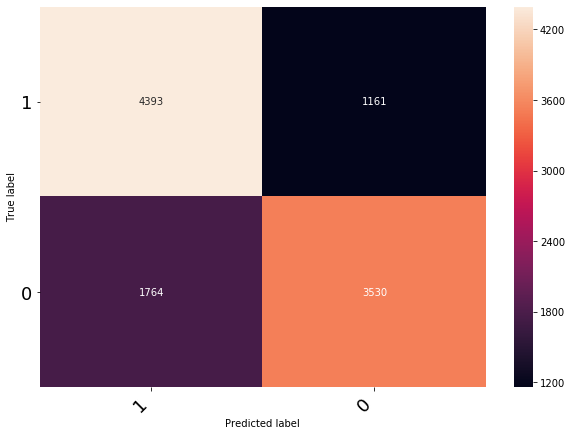

In [136]:
model_test(bag_lr_cl, X_2_scaled, y)

Mean Absolute Error: 0.26216814159292035
              precision    recall  f1-score   support

           0       0.73      0.78      0.75      5554
           1       0.75      0.69      0.72      5294

    accuracy                           0.74     10848
   macro avg       0.74      0.74      0.74     10848
weighted avg       0.74      0.74      0.74     10848



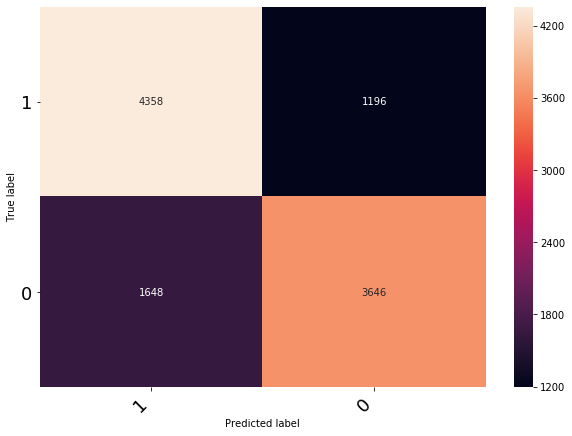

In [172]:
model_test(bg, X_2_scaled, y )

# Models comparison

In [122]:
best_lr = LogisticRegression(C=0.1,penalty='l2' )
best_lr.fit(X_3_scaled, y)
print("The score for training is ", best_lr.score(X_3_scaled, y))

C:\Users\Arwa\Anaconda3\envs\metis\lib\site-packages\sklearn\linear_model\logistic.py:432: FutureWarning: Default solver will be changed to 'lbfgs' in 0.22. Specify a solver to silence this warning.
  FutureWarning)


The score for training is  0.7249663513837418


C:\Users\Arwa\Anaconda3\envs\metis\lib\site-packages\sklearn\linear_model\logistic.py:432: FutureWarning: Default solver will be changed to 'lbfgs' in 0.22. Specify a solver to silence this warning.
  FutureWarning)


Mean Absolute Error: 0.27064896755162243
              precision    recall  f1-score   support

           0       0.71      0.79      0.75      5554
           1       0.75      0.66      0.71      5294

    accuracy                           0.73     10848
   macro avg       0.73      0.73      0.73     10848
weighted avg       0.73      0.73      0.73     10848



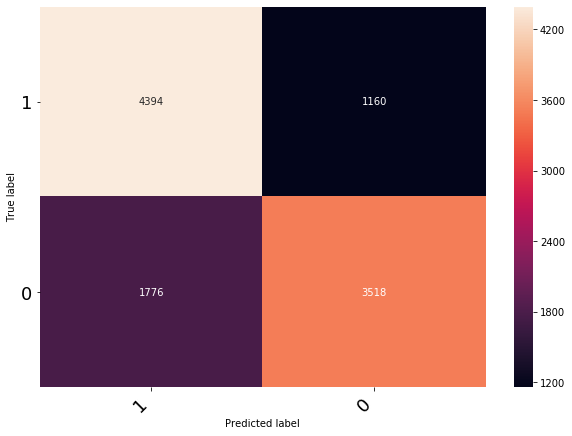

In [123]:
model_test(best_lr,X_3_scaled, y )

In [124]:
best_knn = KNeighborsClassifier(n_neighbors=19)
best_knn.fit(X_3_scaled, y)
print("The score for training is ", best_knn.score(X_3_scaled, y))

The score for training is  0.7440308276637719


Mean Absolute Error: 0.27857669616519176
              precision    recall  f1-score   support

           0       0.72      0.75      0.74      5554
           1       0.73      0.69      0.71      5294

    accuracy                           0.72     10848
   macro avg       0.72      0.72      0.72     10848
weighted avg       0.72      0.72      0.72     10848



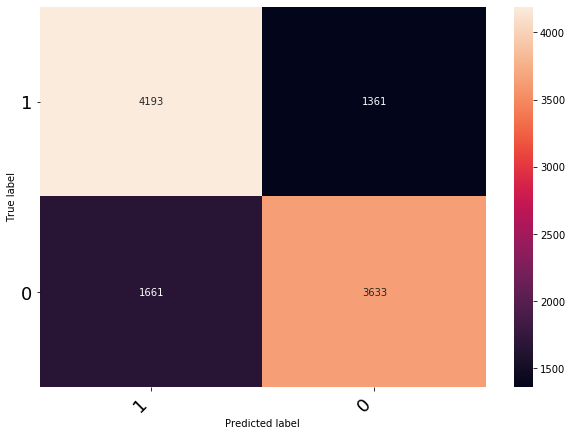

In [125]:
model_test(best_knn,X_3_scaled, y )

In [126]:
best_rf = RandomForestClassifier(n_estimators=150, max_depth=50, max_features=2)
best_rf.fit(X_3_scaled, y)
print("The score for training is ", best_rf.score(X_3_scaled, y))

The score for training is  0.9658351309991334


Mean Absolute Error: 0.27857669616519176
              precision    recall  f1-score   support

           0       0.72      0.75      0.74      5554
           1       0.73      0.69      0.71      5294

    accuracy                           0.72     10848
   macro avg       0.72      0.72      0.72     10848
weighted avg       0.72      0.72      0.72     10848



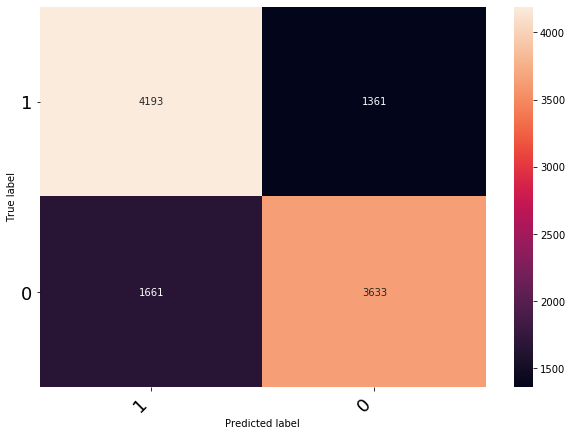

In [127]:
model_test(best_knn,X_3_scaled, y )

In [128]:
import pickle
pickle.dump(best_lr_3, open('best_lr.pkl', 'wb'))

In [129]:
make_report(best_lr)


Accuracy of the best model is : 0.7245575221238938

Confusion Matrix 
-------------------
 [[5457 1508]
 [2227 4368]]

Classification Report 
---------------------
              precision    recall  f1-score   support

           0       0.71      0.78      0.75      6965
           1       0.74      0.66      0.70      6595

    accuracy                           0.72     13560
   macro avg       0.73      0.72      0.72     13560
weighted avg       0.73      0.72      0.72     13560

